#### Deep Learning

# Regression
#### Francisco Maiocchi

***
### Introducción

En problemas de regresión, el objetivo es predecir un valor continuo de salida, como un precio o una probabilidad. Esto difiere de los problemas de clasificación, donde el objetivo es predecir un label discreto. Este ejemplo utiliza el Auto MPG dataset para predecir la eficiencia de consumo de combustible de autos de fines de los 70's y principios de los 80's. Utiliza KERAS que es la API de alto nivel de TensorFlow. Este ejemplo está en web oficial de TensorFlow en https://www.tensorflow.org/tutorials/keras/basic_regression?hl=es  

***
### Imports

In [3]:
# Importo TensorFlow como tf
import tensorflow as tf
# Importo keras
from tensorflow import keras
# Importo el submodulo layers
from tensorflow.keras import layers

# Librerias auxiliares
import numpy as np
import matplotlib.pyplot as plt
from __future__ import absolute_import, division, print_function
import pathlib
import pandas as pd # Se usa para tener los datos en formato tabla
import seaborn as sns # Para gráficos estadisticos

print(tf.__version__)

1.12.0


***
### Obtención del dataset
Primero lo descargamos

In [4]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 6us/step


'C:\\Users\\Francisco\\.keras\\datasets\\auto-mpg.data'

Ahora lo importamos usando pandas

In [5]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
# Lo leo utilizando pandas y nombro las columnas
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
# Tail muestra los últimas 5 filas
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


***
### Limpieza del dataset
Como existen algunos valores no conocidos en el dataset, debemos limpiarlo.

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Lo que hace .isna() es detectar valores faltantes en un DataFrame. Luego sumamos todos los de la misma columna.  

Para mantener el tutorial sencillo, vamos a eliminar esas filas con valores faltantes.


In [9]:
dataset = dataset.dropna()
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

La columna origen representa categorías, no números. Por eso es mejor hacer un ecoder one-hot que funciona mejor en lo que es Machine Learning. Esto consiste en representar cada categoría con columnas distintas con valores binarios.

In [10]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


***
### Dividimos el set para entrenamiento y test

In [11]:
# Devuelve una porción random del dataset
train_dataset = dataset.sample(frac=0.8,random_state=0)
# Elimina los ejemplos que se utilizan en el train_dataset
test_dataset = dataset.drop(train_dataset.index)

***
### Inspeccionamos un poco los datos
Primero vamos a inspeccionar un poco la distribución de algunas columnas del set de entrenamiento.

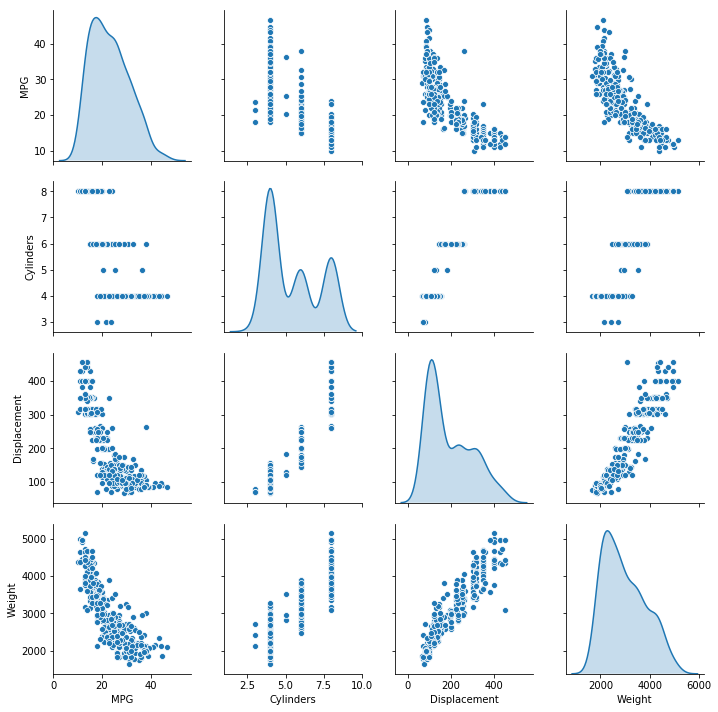

In [12]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Tambien vemos las estadisticas generales

In [13]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


Dentro de nuestra tabla de entrenamiento, también tenemos los labels. Proceedemos a sacaralos.

In [14]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

***
### Normalizamos los datos
En la tabla anterior podemos ver que cada feauture tiene un rango muy distinto. Es una buena practica normalizar cada feauture que usa diferentes escalas. ESTA NORMALIZACION INFLUYE BASTANTE, SE PUEDE PROBAR CON DISTINTAS.

In [15]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

***
### Armado del modelo
Vamos a utilizar un modelo secuencial con dos capas ocultas fully-connected y una capa de salida que devuelve un único valor continuo. Lo enmarcamos dentro de una función ya que luego crearemos otro modelo.

In [16]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.train.RMSPropOptimizer(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Ahora vamos a probar el modelo con 10 ejemplos para ver que es lo que devuelve.

In [17]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.511311  ],
       [-0.4024998 ],
       [-0.05980638],
       [-0.54383343],
       [-0.39598864],
       [-0.33618158],
       [-0.46511734],
       [-0.12781808],
       [-0.16124876],
       [-0.21225908]], dtype=float32)

***
### Entrenamiento del modelo
El modelo es entrenado por 1000 épocas y se guarda la eficacia del entrenamiento y de la validación.

In [18]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Observamos el progreso del entrenamiento usando las estadisticas guardadas en history

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
995,9.713160,2.388844,9.713160,2.516554,1.084769,2.516554,995
996,9.718153,2.349138,9.718153,3.015185,1.131001,3.015185,996
997,9.939599,2.377042,9.939599,2.549429,1.025824,2.549429,997
998,9.745148,2.355924,9.745148,2.630453,1.050731,2.630453,998
999,9.820991,2.338714,9.820991,2.669428,1.084787,2.669428,999


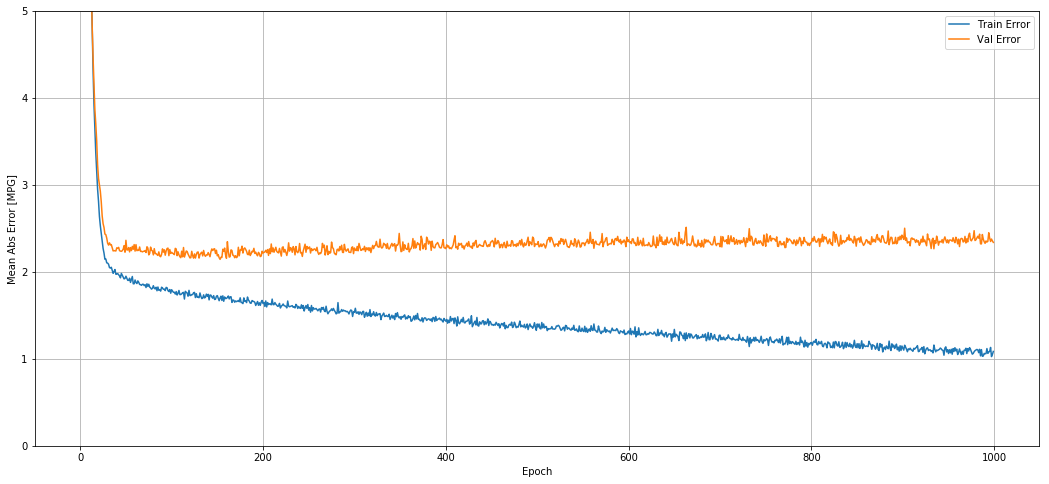

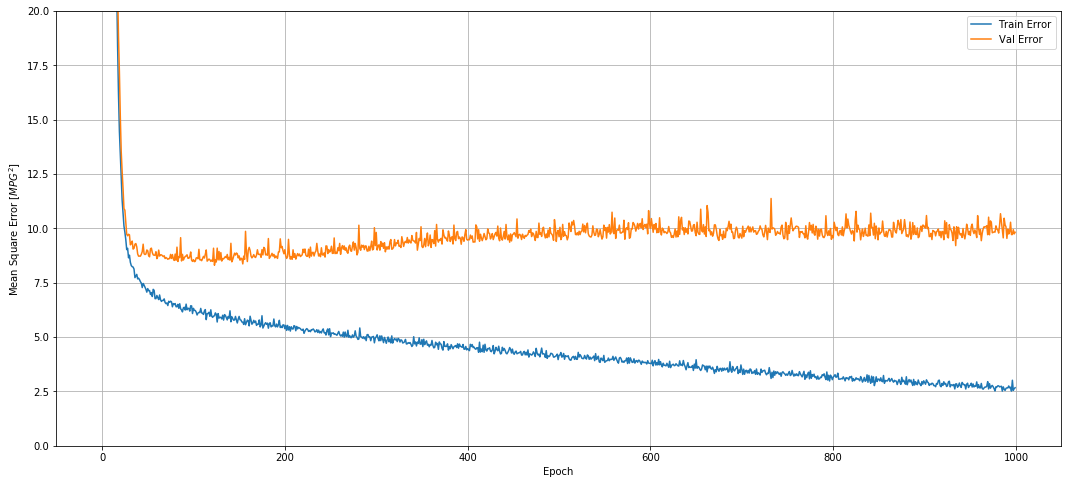

In [21]:
def plot_history(history):
    plt.figure(figsize=(18,8))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.grid()
    plt.legend()
    plt.ylim([0,5])

    plt.figure(figsize=(18,8))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.grid()
    plt.legend()
    plt.ylim([0,20])

plot_history(history)

Podemos ver que la validación no mejora más alla de las 100 épocas. Es más, empeora. Podemos mejorar el modelo y hacer que frene automaticamente cuando la validación no mejora. Se utiliza un callback que establece una condición para seguir entrenando cuando termina una epoca. Si pasan algunas épocas sin mejorar, se deja de entrenar.


....................................................................................................
................................................................................................

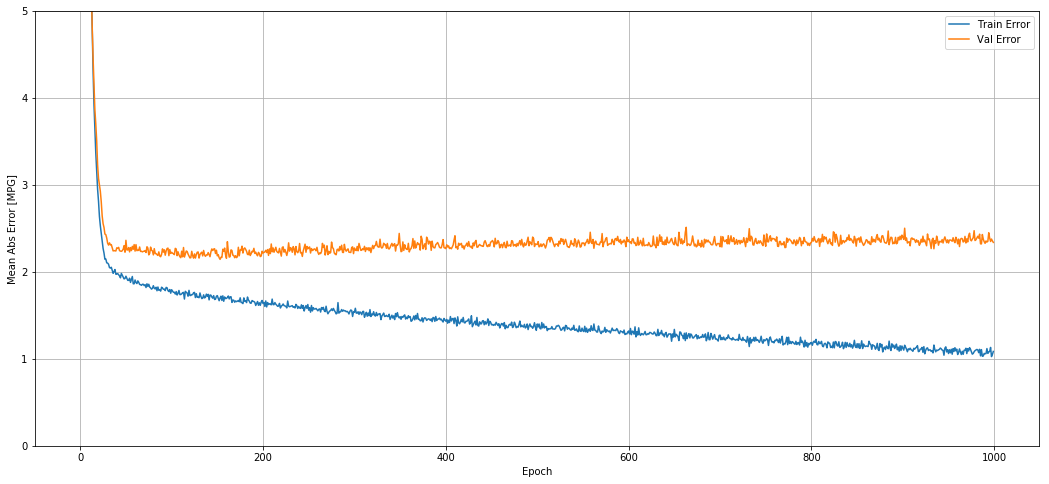

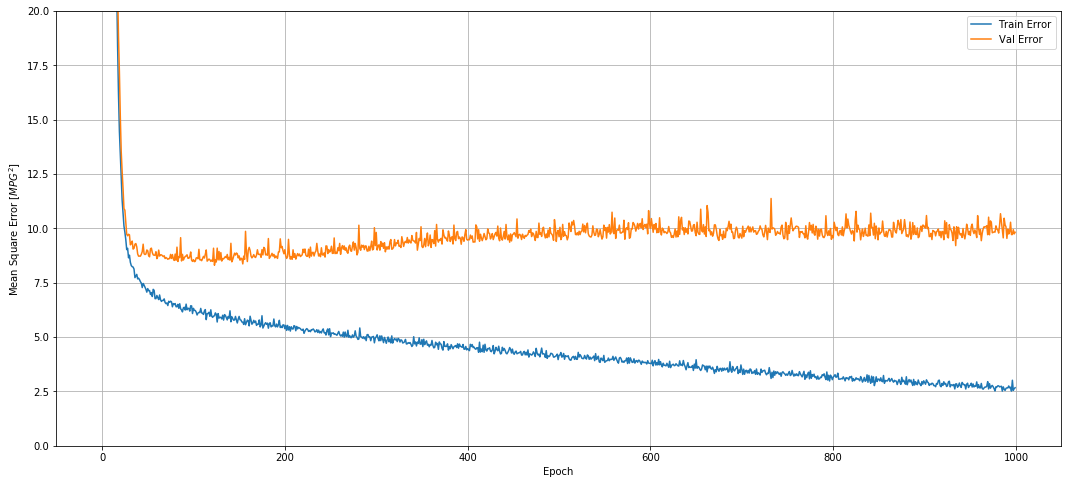

In [22]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

Ahora veremos como se desempeña con set de test.

In [23]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.80 MPG


Vemos que funciona mejor con el test que en la validación

***
### Predicciones

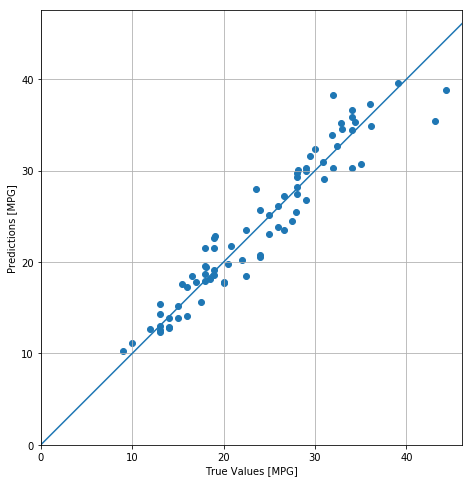

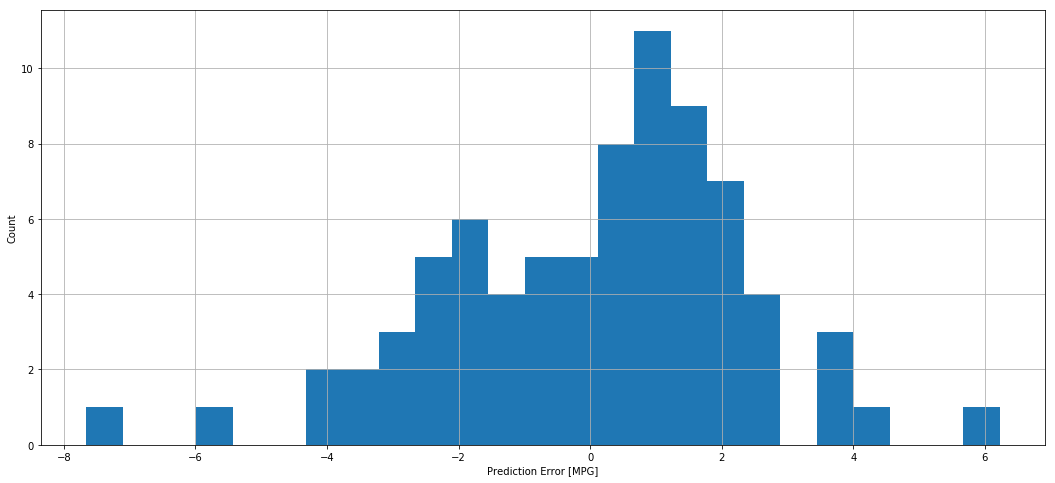

In [30]:
test_predictions = model.predict(normed_test_data).flatten()

plt.figure(figsize=(8,8))
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.grid()
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

plt.figure(figsize=(18,8))
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.grid()
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

***
### Conclusiones
Hemos intrudico algunas técnicas para tratar con problemas de regresión.  

+ El error cuadrático medio (MSE) es una loss function muy común para este tipo de problemas.
+ Una métrica bueno para estos problemas es el error absoluto medio (MAE).
+ Cuando los feautures de entrada tienen diferentes rangos, es necesario escalarlos de forma independiente.
+ Si no hay muchos datos, es preferible utilizar un red pequeña con pocas capas ocultas para evitar el overfitting.